In [170]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [171]:
"""
This notebook is to illustrate the Transformer architecture.
Steps are followed by my article post: 
https://waylandzhang.github.io/en/let-s-code-llm.html
"""

'\nThis notebook is to illustrate the Transformer architecture.\nSteps are followed by my article post: \nhttps://waylandzhang.github.io/en/let-s-code-llm.html\n'

In [172]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [173]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

In [174]:
# Using TikToken to tokenize the source text: https://github.com/openai/tiktoken?tab=readme-ov-file
# The way of using TikToken for your own datasets 
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [175]:
# Illustration purpose, and show how the tokenized text looks like
print(encoding.encode('Chapter 1: Building Rapport and Capturing Attention')) # "Token Value" (max vaule = 100069) is different from "Text Index" (Tokenized text size, max = 77919)
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711, 63120])) # "Rapport" is tokenized vaule as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449])) # "Attention" is tokenized as two tokens: "At"[88861] and "tention"[279]

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711, 63120]
Chapter 1: Building Rapport and Capturing Attention
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


In [176]:
# Split train and validation dataset
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [177]:
# Define the device, device is set to CUDA if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,)).to(device) # Randomly sample the starting "Text Index" (Tokenized text size, max = 77919) of each batch
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs]) # Get the context_length tokens
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs]) # Shift the target by one token

# Check the shape of the batch
print(len(idxs), len(data), (batch_size,), idxs)
print(x_batch.shape, y_batch.shape)
print(x_batch)
print(y_batch)

cuda
4 70127 (4,) tensor([35754, 55550, 63572,  1447], device='cuda:0')
torch.Size([4, 16]) torch.Size([4, 16])
tensor([[  279,  6763,  1920,    13,   578,  5845,   311, 13750, 19570,   279,
           907,   323,  7720,   315,  1057,  3956],
        [ 3495, 14955,    11,   477,  5064, 23146,   430,  9788,   279, 66732,
           315,   701, 10209,    13,  3296, 32644],
        [38769, 10742,    11, 20958,   264,  6928, 19451,    11, 11125, 64784,
            11,   323, 56501, 54111,   439,  6975],
        [43496,   872,  8830,   719,  1101,  3727,   279,  6130,  2733,  6755,
           323, 16365,   627, 29831, 19682,  5900]], device='cuda:0')
tensor([[ 6763,  1920,    13,   578,  5845,   311, 13750, 19570,   279,   907,
           323,  7720,   315,  1057,  3956,   477],
        [14955,    11,   477,  5064, 23146,   430,  9788,   279, 66732,   315,
           701, 10209,    13,  3296, 32644,  1521],
        [10742,    11, 20958,   264,  6928, 19451,    11, 11125, 64784,    11,
     

In [178]:
# Illustration purpose, Pandas is a Data visulation tool
pd.set_option('display.expand_frame_repr', False)
print("Our x_batch:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))
print("Our y_batch:\n", pd.DataFrame(y_batch.data.detach().cpu().numpy()))

print(encoding.decode(x_batch[0].tolist()))
print(encoding.decode(y_batch[0].tolist()))

Our x_batch:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900
Our y_batch:
       0     1      2     3      4      5      6      7      8    9      10     11     12     13     14     15
0   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956    477
1  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644   1521
2  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    

In [179]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model).to(device) # random initialized a look-up table, Embedding(100070, 64), value should be updated during training 
print("Token Embedding Look-up table: ", token_embedding_lookup_table)
print(token_embedding_lookup_table.weight.data) # Randomly initialized

# desplay the min and max value of the token embedding look-up table
token_embedding_lookup_table.weight.data.min().item(), token_embedding_lookup_table.weight.data.max().item()

Token Embedding Look-up table:  Embedding(100070, 64)
tensor([[ 0.6258,  0.0255,  0.9545,  ...,  1.4738,  0.0688,  1.3327],
        [-0.4970,  0.4658, -0.2573,  ..., -0.6939, -0.3252,  1.2439],
        [ 1.3471,  1.6910, -0.1244,  ..., -0.9786, -0.4320, -1.4938],
        ...,
        [ 0.1471,  0.5790, -0.6682,  ..., -1.0645,  1.2904, -1.1105],
        [ 0.4153, -0.3456,  0.4415,  ...,  1.3334,  0.3723,  0.7225],
        [ 1.9651, -0.6380, -1.3955,  ...,  0.0445,  0.8359, -0.7229]],
       device='cuda:0')


(-5.069180488586426, 5.4419074058532715)

In [180]:
# Get the embedding of the x_batch and y_batch
x_batch_embedding = token_embedding_lookup_table(x_batch) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch)

# Get x embedding
print(x_batch.data)
# The first token embedding of the first batch as the x_batch contains "Token Index" (max = 77919) of the first batch
print(x_batch_embedding[0, 0, :]) 

x_batch_embedding.shape, y_batch_embedding.shape

tensor([[  279,  6763,  1920,    13,   578,  5845,   311, 13750, 19570,   279,
           907,   323,  7720,   315,  1057,  3956],
        [ 3495, 14955,    11,   477,  5064, 23146,   430,  9788,   279, 66732,
           315,   701, 10209,    13,  3296, 32644],
        [38769, 10742,    11, 20958,   264,  6928, 19451,    11, 11125, 64784,
            11,   323, 56501, 54111,   439,  6975],
        [43496,   872,  8830,   719,  1101,  3727,   279,  6130,  2733,  6755,
           323, 16365,   627, 29831, 19682,  5900]], device='cuda:0')
tensor([ 1.3997, -1.2069,  0.3280, -0.2511,  0.5319, -0.2482,  0.3519, -0.3892,
         0.1300, -1.2076,  0.5099,  0.4865,  0.9830, -0.5211, -1.7399, -0.4237,
        -0.2153, -0.1627,  0.2509,  1.1936, -0.2294,  1.8213, -0.4326, -0.8606,
        -0.9966,  1.0801, -0.4100, -0.7973,  0.3653, -0.3421, -0.2485, -0.3359,
         0.2612,  0.5806, -0.2503,  2.1764, -0.6799,  1.0881, -0.8908, -0.1599,
        -1.0095, -0.6344,  0.7906,  0.2364, -0.5984, -0.60

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [181]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model).to(device)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1) 
# torch.arange(0, d_model, 2).float(): Creates a 1D tensor with values (.float():Converts the tensor to a float type) starting from 0 up to (but not including) d_model, with a step size of 2. 
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # math equation: 1 / (10000 ^ (2i/d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


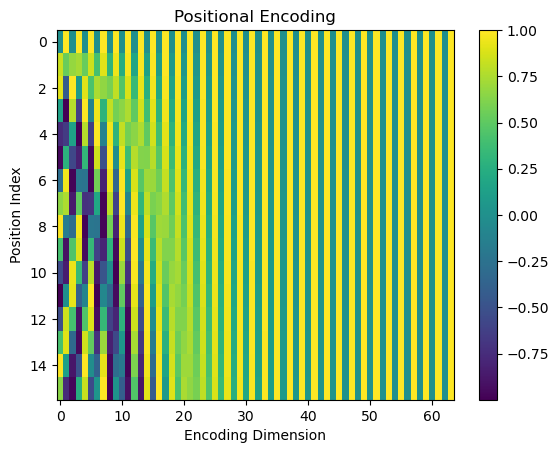

In [182]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [183]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.399742,-0.206918,0.327990,0.748870,0.531874,0.751807,0.351938,0.610762,0.129977,-0.207580,...,-0.547752,2.515671,1.223743,1.833670,-0.404194,1.563555,0.591292,0.275255,1.670105,0.758279
1,1.407957,-0.561974,2.393893,0.377252,1.083746,0.138066,-0.334590,1.670161,0.329176,2.342795,...,0.873984,2.226714,0.794747,1.598629,0.884658,1.032520,1.353795,1.059697,1.172643,1.527427
2,0.482819,1.301215,0.653670,-0.846175,0.628521,1.126829,-0.102938,-0.636202,0.428573,0.553769,...,-0.934116,2.145729,-1.913517,0.552654,0.597746,2.673483,-1.969119,1.397835,-0.438208,0.437077
3,0.851059,0.379319,0.070685,0.910763,-1.117662,0.325378,0.947827,0.472564,0.516017,0.790074,...,0.072798,0.264451,0.070916,-1.744750,1.088080,0.002188,0.715526,-0.357311,1.604357,1.920290
4,-2.720048,-0.354717,0.272903,-0.906938,0.932237,-1.449321,-0.226828,-1.203768,2.488952,2.130765,...,0.533600,0.432145,-2.389682,0.913403,0.066965,1.655225,0.625080,0.236625,-0.692241,0.992275
5,-0.147775,0.718796,0.559903,-0.004127,-0.690035,-0.998508,0.331355,-1.222723,0.836060,-1.353497,...,-0.044886,-0.201054,-0.926252,1.322522,0.587324,1.108183,-1.652407,2.918813,0.942309,1.584330
6,0.038134,3.066611,-1.069607,0.424900,-1.142844,-2.948736,0.505219,-0.617680,1.280667,-0.168857,...,0.202646,1.051821,1.306703,1.517673,0.050767,1.044631,1.347860,0.678610,-0.477987,0.833080
7,-1.368717,2.010294,-1.177933,1.943613,0.931115,-2.610583,-0.812628,-1.958096,2.302625,0.242536,...,-2.336618,1.190780,-0.052987,3.281737,-0.415515,0.198294,-1.392472,2.863094,-0.392633,0.868254
8,3.896336,-0.053480,-1.065470,1.569054,-1.767442,-0.238040,-1.386770,-0.574759,0.118923,-1.069920,...,3.366446,0.203255,1.759607,2.526687,-0.652322,2.660683,0.966853,1.618786,1.664013,2.768385
9,1.811860,-2.118048,0.777184,0.642304,-0.407949,0.093468,-0.256171,-1.183092,0.421236,-2.164224,...,-0.543957,2.515664,1.226589,1.833666,-0.402059,1.563552,0.592893,0.275254,1.671305,0.758279


In [184]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [185]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model).to(device)
Wk = nn.Linear(d_model, d_model).to(device)
Wv = nn.Linear(d_model, d_model).to(device)

# This reshaping is necessary to split the d_model dimension into multiple heads for parallel attention computation.
Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16] # Reshape Q for multi-head attention

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# batch_size: The number of sequences in a batch.
# -1: This dimension is inferred from the other dimensions. It typically represents the sequence length.
# num_heads: The number of attention heads.
# d_model // num_heads: The dimension of each attention head.

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.843055 -0.550052 -0.127732 -0.844841 -0.819224  0.063522 -0.187879  1.182711 -1.542636  0.582238  0.123996 -0.023149  0.141312  0.812356 -1.628145  0.312126
1 -0.350486  0.484634 -0.140094  0.746821  1.481563 -0.266804  0.312059 -0.710153 -0.557109  0.462987 -0.575465  0.824084 -0.910005 -0.060633 -0.851141 -0.696344
2 -0.140998 -0.055692 -0.718412 -0.797249  0.366570  1.513673  0.577341 -0.707246 -0.275017  1.270265 -0.846118 -1.158900  1.652280  0.261800 -0.884520 -0.846511
3 -0.244500  0.759894  0.067822  0.388658 -0.178537  1.044808 -0.276759 -0.887758 -0.158977 -0.619547 -0.298364 -0.604880 -1.250720  0.388842 -1.088378  0.081781
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.614938 -0.657467  0.080

In [186]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]    

          0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0   0.843055 -0.550052 -0.127732 -0.844841 -0.819224  0.063522 -0.187879  1.182711 -1.542636  0.582238  0.123996 -0.023149  0.141312  0.812356 -1.628145  0.312126
1   0.614938 -0.657467  0.080918 -0.701147 -0.332033 -0.185407 -1.033170  0.447317  0.462455  0.497301 -0.083056 -1.593413  0.454453  0.745469 -1.651096  0.451588
2   0.477557 -0.665898 -0.062522 -0.844530 -0.971296 -0.579648 -0.250835  0.137787  0.971834  0.627744 -0.350412 -1.107924  1.009746  0.223489 -1.007623  0.238047
3   0.306343  1.002409 -0.558756 -0.368392 -0.373141 -1.728941  0.253534  0.143261  0.430667  0.641169 -1.484428 -0.382139  0.807904  0.482248 -1.512201  1.232279
4   1.438333 -0.953410 -0.510782 -0.506377  0.031280 -0.456936  0.935150  0.421769 -0.444609  1.587090  1.122377  0.088356 -0.050521 -0.872715 -0.639425  0.572517
5  -0.098004 -1.362101

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,0.872087,0.805252,0.638937,0.403635,-0.220579,0.074281,0.066308,0.161097,0.776865,-0.015753,0.059171,-0.167397,-0.519080,-0.113654,0.370162
1,1.123528,0.464093,0.514921,-0.184883,0.292600,-0.127225,0.205937,0.207778,0.602376,1.016719,0.158707,0.074483,0.526718,0.460966,0.633765,0.534267
2,1.040624,0.605708,0.119165,-0.133348,-0.169015,-0.146091,0.444743,0.050206,0.774002,0.830742,-0.216136,-0.111672,0.751037,0.496729,0.747770,0.609336
3,0.900045,0.596818,0.359724,0.836026,0.074438,0.652813,1.057635,-0.026944,1.124048,0.971823,-0.467323,-0.247706,0.002623,-0.360195,0.017814,0.965252
4,1.061119,1.158659,0.633724,-0.320907,0.383561,-0.448183,-0.238576,-0.078154,-0.033891,0.852194,0.056047,0.533376,0.968321,0.675573,0.506570,0.651593
5,0.071059,0.273445,0.044782,0.250272,-0.114290,0.121239,0.472958,0.086112,-0.077087,-0.158122,-0.416886,0.212225,0.220158,-0.492304,0.175022,0.505993
6,0.897961,1.322749,0.553525,0.079147,0.502846,-0.506932,0.223247,-0.400829,0.203914,0.658944,-0.018270,0.620021,0.600703,0.066074,0.316328,0.332746
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-0.025749,0.031660,0.079259,0.274235,0.095197,-0.625558,-0.000797,0.226548
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,0.642808,0.532076,0.191681,-0.066689,0.383821,-0.080174,0.330104
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035514,-0.006276,0.174739,0.899135,0.184269,0.238904,-0.084467,-0.414828,-0.173580,0.431657


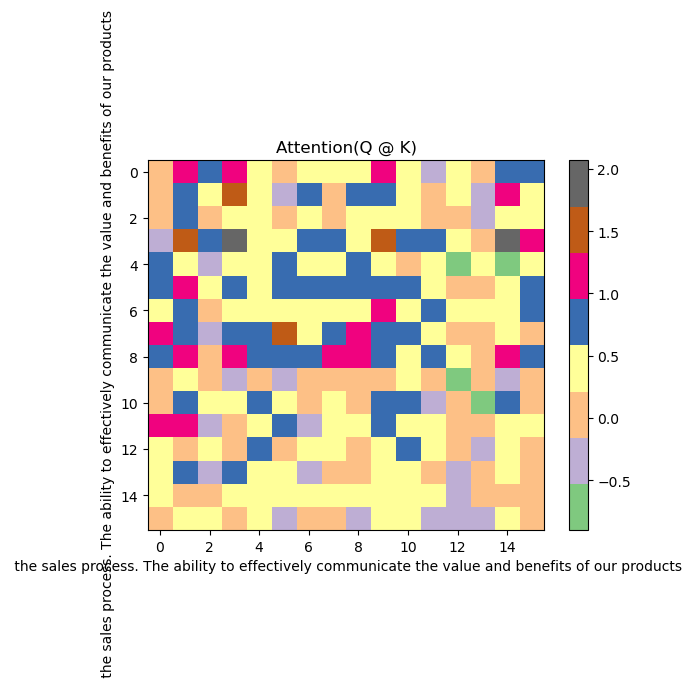

In [187]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,1.123528,0.464093,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,1.040624,0.605708,0.119165,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.900045,0.596818,0.359724,0.836026,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,1.061119,1.158659,0.633724,-0.320907,0.383561,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.071059,0.273445,0.044782,0.250272,-0.114290,0.121239,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.897961,1.322749,0.553525,0.079147,0.502846,-0.506932,0.223247,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035514,-0.006276,0.174739,0.899135,-inf,-inf,-inf,-inf,-inf,-inf


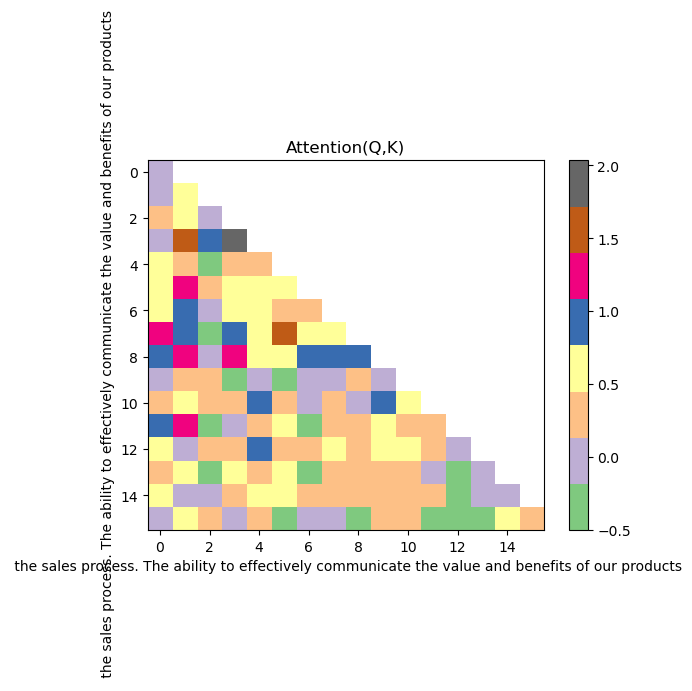

In [188]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]).to(device), diagonal=1).bool(), float('-inf')) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only 
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [189]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.659133,0.340867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.488936,0.316498,0.194566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.306845,0.226584,0.178756,0.287816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.284609,0.313769,0.185624,0.071457,0.144541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.159313,0.195051,0.155182,0.190583,0.132360,0.167512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.195804,0.299437,0.138751,0.086341,0.131894,0.048049,0.099724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.100501,0.213640,0.183525,0.068726,0.121962,0.092737,0.131933,0.086976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.176701,0.085500,0.131407,0.107381,0.128974,0.074929,0.052437,0.110609,0.132063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.148425,0.116194,0.097110,0.168735,0.096496,0.046389,0.056222,0.057891,0.069378,0.143160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [190]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [191]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [192]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model).to(device)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.064506,0.451883,0.126058,-0.308508,0.429776,-0.321017,0.028085,0.494516,0.014582,-0.300572,...,0.401453,0.703710,-0.791798,0.423244,0.758770,0.434047,-0.165581,-0.510981,-0.012390,0.565687
1,-0.319784,0.270716,-0.050118,-0.361193,0.337563,-0.242993,0.135025,0.104678,0.128337,-0.151392,...,0.253589,0.731760,-0.598175,0.584505,0.856153,0.657069,-0.114799,-0.277092,0.109785,0.568027
2,-0.142773,0.471190,-0.135125,-0.391242,0.240273,-0.426438,0.191585,0.249497,0.114119,-0.148854,...,0.188330,0.707296,-0.513143,0.675920,0.843664,0.519398,0.241321,-0.254675,-0.067157,0.583508
3,-0.112123,0.188070,-0.195295,-0.499538,0.074381,-0.364622,0.126506,0.199517,0.166654,-0.116992,...,0.050666,0.629354,-0.457674,0.544949,0.920907,0.465222,0.169629,-0.187357,0.040276,0.363001
4,-0.020715,0.262572,-0.107539,-0.486144,0.098776,-0.386885,0.132087,0.430532,0.070903,-0.235981,...,0.107817,0.448574,-0.550493,0.264393,0.794210,0.431990,0.282289,-0.231657,-0.063665,0.233252
5,0.008326,0.399232,-0.110658,-0.406787,0.053074,-0.316901,0.138022,0.376357,0.234606,-0.272379,...,0.189062,0.355173,-0.501581,0.171572,0.708473,0.260176,0.336405,-0.285479,-0.020590,0.198434
6,-0.124724,0.291068,-0.078329,-0.373831,0.082521,-0.331801,0.086711,0.314733,0.143774,-0.316908,...,0.183282,0.388413,-0.533431,0.296272,0.681266,0.266746,0.207132,-0.252256,-0.067646,0.238893
7,-0.095166,0.354915,-0.023955,-0.282569,0.061036,-0.429683,0.220803,0.376843,0.187381,-0.233588,...,0.265134,0.267361,-0.426334,0.250288,0.574936,0.035811,0.334888,-0.203362,-0.035591,0.152928
8,-0.214826,0.306409,-0.111830,-0.316602,0.210473,-0.285486,0.234773,0.146622,0.178420,-0.231031,...,0.293021,0.345010,-0.355211,0.474156,0.595329,0.373845,0.198910,-0.092789,0.023336,0.254177
9,-0.150454,0.300733,-0.084071,-0.347423,0.197579,-0.288124,0.055311,0.199533,0.170684,-0.402754,...,0.265382,0.349139,-0.415729,0.308192,0.549358,0.390737,0.178057,-0.118175,-0.048890,0.205317


In [193]:
# Add residual connection
output = output + X

print(X)

tensor([[[ 1.3997, -0.2069,  0.3280,  ...,  0.2753,  1.6701,  0.7583],
         [ 1.4080, -0.5620,  2.3939,  ...,  1.0597,  1.1726,  1.5274],
         [ 0.4828,  1.3012,  0.6537,  ...,  1.3978, -0.4382,  0.4371],
         ...,
         [ 1.0455, -0.2213, -2.7943,  ...,  2.6424, -0.1543,  0.0696],
         [-0.0075,  1.1609, -0.6728,  ...,  1.2277,  0.5831,  1.2854],
         [ 1.1624, -1.1632, -2.2520,  ...,  0.3632,  0.7527,  1.6645]],

        [[-0.4001,  0.4520,  0.0993,  ...,  0.6679, -0.0513,  1.9338],
         [ 2.2621,  0.6850, -0.8629,  ...,  1.6701, -2.0246,  1.9768],
         [ 1.2842, -0.4584,  1.7172,  ...,  1.1141,  0.1623,  1.2443],
         ...,
         [ 1.1301,  2.2768, -1.0258,  ..., -0.3573,  1.6057,  1.9203],
         [ 2.1231, -0.8362, -0.1373,  ...,  2.2694, -0.5724, -0.3812],
         [ 1.9026, -0.4869, -0.8852,  ...,  2.3133,  2.0033,  0.0653]],

        [[ 0.6600, -1.7690, -0.7865,  ..., -0.1405, -1.0833,  0.9306],
         [-0.6109,  1.3955,  0.6401,  ...,  0

In [194]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output_layernorm = layer_norm(output)

print(output_layernorm)

tensor([[[ 0.6511, -0.3388, -0.1489,  ..., -0.7752,  0.9439,  0.6409],
         [ 0.3631, -0.8491,  1.4665,  ...,  0.0946,  0.5338,  1.2483],
         [-0.0747,  0.9808,  0.0568,  ...,  0.5171, -0.6977,  0.4268],
         ...,
         [ 0.5356, -0.0708, -2.7151,  ...,  1.9570, -0.3951, -0.0394],
         [-0.4078,  1.1573, -1.0637,  ...,  0.8031,  0.0969,  1.1079],
         [ 0.6067, -1.0120, -2.3187,  ..., -0.0784,  0.2086,  1.2981]],

        [[-0.4134,  0.1839, -0.2932,  ..., -0.6772, -0.5287,  1.2952],
         [ 1.1228, -0.0482, -1.0816,  ...,  0.3199, -2.0572,  1.2258],
         [ 0.6039, -1.1898,  1.3793,  ...,  0.2635, -0.1703,  1.1046],
         ...,
         [ 0.5072,  1.5574, -1.3249,  ..., -0.8612,  0.8379,  1.3021],
         [ 1.3412, -0.9431, -0.6329,  ...,  1.3442, -0.9748, -0.6610],
         [ 1.2141, -0.8009, -1.3564,  ...,  1.5598,  1.3498, -0.2547]],

        [[-0.2548, -2.0201, -1.1657,  ..., -0.9927, -1.2197,  0.2397],
         [-1.3374,  0.9457,  0.1329,  ..., -0

In [195]:
# Define Feed Forward Nural Network
output = nn.Linear(d_model, d_model * 4).to(device)(output_layernorm)
output = nn.ReLU().to(device)(output)
output = nn.Linear(d_model * 4, d_model).to(device)(output)
output = torch.dropout(output, p=dropout, train=True)

In [196]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [197]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [198]:
# Apply the final linear layer to get the logits
# linear_layer is a linear layer with d_model input features and max_token_value + 1 output features.
# output ([4, 16, 64]) -> logits ([4, 16, 100070])
logits = nn.Linear(d_model, max_token_value+1).to(device)(output) 
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,-0.155801,0.180464,0.596153,-0.017949,0.041366,-0.121851,0.794354,-0.068633,-0.318771,-0.646453,...,1.370128,0.093723,-0.379898,-0.025110,-0.327244,-0.936955,0.020995,0.644994,0.959250,0.390118
1,-0.422077,-0.251443,1.352230,0.825049,0.398474,-0.052612,0.504487,-0.144751,-0.214228,-0.637778,...,-0.217320,0.292034,-0.546733,-0.013349,-0.555951,0.222636,-0.470434,0.196748,0.412378,0.382209
2,-0.571919,-0.733111,0.623412,-0.169563,0.538070,0.446169,0.754747,-0.599769,-0.319450,0.165487,...,-0.369003,0.085314,-0.203124,-0.382793,-0.219660,0.042205,0.831860,0.396190,0.412346,0.613144
3,-0.432240,-0.337134,0.573549,0.538490,0.165933,0.382928,0.124495,-0.597629,-0.848559,0.530635,...,0.267792,-0.496862,-0.840303,0.668603,-0.446612,0.310760,0.008038,0.507530,0.962340,0.321170
4,-1.189753,-0.544193,-0.424656,-0.816279,0.283897,0.320089,0.824761,-0.230124,-0.468414,-0.073064,...,1.058757,-0.636552,-0.683171,-0.752391,-0.520178,-0.998149,0.375524,1.235225,0.594753,0.361166
5,-0.893875,-0.991275,-0.740569,-0.362141,-0.586138,0.169634,0.771174,-0.590870,-0.603846,-0.038604,...,0.683018,-0.562341,-1.269034,0.164081,0.088032,0.533080,0.032025,1.200413,0.601406,-0.016751
6,-1.310853,-0.240104,-0.148195,-0.120697,-0.709319,0.929838,0.353181,0.294274,-0.271819,1.008236,...,-0.668948,-1.025035,-0.028996,0.446405,-0.454804,-0.117286,-1.417938,0.065225,0.386163,0.179430
7,-0.354717,-0.936021,0.729367,-0.142910,0.375530,0.004785,-0.046803,0.268830,0.148272,0.107369,...,-0.795772,-0.626380,-0.796488,-0.116123,-1.238129,0.058336,-0.007507,0.242190,-0.497700,-0.541448
8,-0.623057,-0.663126,-0.072224,-0.882645,0.010632,0.395116,0.183503,-0.265350,-0.326854,0.800916,...,-0.088186,-0.354037,-0.438855,1.595173,0.266051,-0.055872,-1.050112,-0.111950,1.034483,0.318923
9,-0.612739,-0.067706,0.305166,-0.167778,-0.586366,-0.342753,0.679522,-0.328543,-0.556313,-0.167517,...,1.371566,0.201304,-0.203405,0.844462,-0.113972,-0.885515,-0.229055,0.618441,1.235993,0.636136


In [203]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())

print(probabilities.shape)

torch.Size([4, 16, 100070])


In [215]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[1,15]).item()
encoding.decode([predicted_index])

' let'

In [201]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'

In [202]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html